<a href="https://colab.research.google.com/github/PadmajaVB/Sexist-Statement-Detection/blob/main/BaselineRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline model with simpleRNN layer

**Importing libraries and cleaning the data**

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import re
import collections

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv", index_col=0)
df_val = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/val_dataset.csv", index_col=0)
df_test = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/test_dataset.csv", index_col=0)

df_train.head()

,Sentences,Label
0,after receiving positive comments for some des...,1
1,i love how all the lynx space YMCA adverts ass...,0
2,aye even here these dolts still see us as poss...,1
3,why are cold showers good for you,0
4,im a physicist and i worked on vacuum systems ...,1


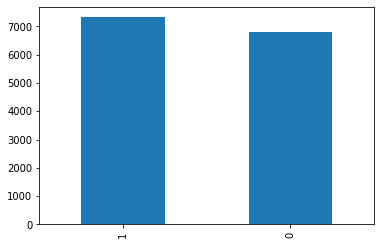

In [ ]:
# do some exploratory data analysis
df_train['Label'].value_counts().plot(kind='bar')

In [ ]:
# clean the data
def clean_data(df):
  df.Sentences = [element.lower() for element in df.Sentences]
  df.Sentences = [re.sub(r'[^a-zA-Z /n]', '', element) for element in df.Sentences]
  df.Sentences = ['<s> '+ element + ' </s>' for element in df.Sentences]
  return df

In [ ]:
df_train = clean_data(df_train)
df_val = clean_data(df_val)
df_test = clean_data(df_test)

**Tokenizing text with a fixed vocabulary size**

In [ ]:
vocab_size = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token='UNK'
)

tokenizer.fit_on_texts(df_train["Sentences"])
train_data = tokenizer.texts_to_sequences(df_train["Sentences"])
reverse_dict = {j:i for i,j in tokenizer.word_index.items()}

In [ ]:
val_data = tokenizer.texts_to_sequences(df_val["Sentences"])
test_data = tokenizer.texts_to_sequences(df_test["Sentences"])

**Create tf.Dataset**

In [ ]:
def create_dataset(x,y):
  ragged_x = tf.ragged.constant(x)
  ragged_y = tf.ragged.constant(y)
  dataset = tf.data.Dataset.from_tensor_slices((ragged_x,ragged_y))
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(32)
  dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None]), y), num_parallel_calls=3)
  dataset = dataset.prefetch(3)
  return dataset

In [ ]:
dataset_train = create_dataset(train_data, df_train["Label"])
dataset_val = create_dataset(val_data, df_val["Label"])
dataset_test = create_dataset(test_data, df_test["Label"])

In [ ]:
print(dataset_train)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.int32, tf.int64)>


**Define and train model**

In [ ]:
# baseline model

Inputs=  tf.keras.layers.Input(shape=(None,))
Embedding= tf.keras.layers.Embedding(vocab_size, 300)(Inputs)
RNN_1= (tf.keras.layers.SimpleRNN(32, return_sequences=False))(Embedding)
Dense= tf.keras.layers.Dense(1, activation= 'sigmoid')(RNN_1)
model= tf.keras.Model(inputs= Inputs, outputs= Dense)
model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 300)         1500000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                10656     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,510,689
Trainable params: 1,510,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history= model.fit(dataset_train, epochs=10, validation_data = dataset_val)

Epoch 1/10
441/441 [==============================] - 51s 112ms/step - loss: 0.6897 - accuracy: 0.5175 - val_loss: 0.6796 - val_accuracy: 0.5751
Epoch 2/10
441/441 [==============================] - 48s 109ms/step - loss: 0.6859 - accuracy: 0.5281 - val_loss: 0.6763 - val_accuracy: 0.5714
Epoch 3/10
441/441 [==============================] - 48s 109ms/step - loss: 0.6853 - accuracy: 0.5306 - val_loss: 0.6829 - val_accuracy: 0.5714
Epoch 4/10
441/441 [==============================] - 48s 107ms/step - loss: 0.6893 - accuracy: 0.5258 - val_loss: 0.6883 - val_accuracy: 0.5421
Epoch 5/10
441/441 [==============================] - 48s 108ms/step - loss: 0.6897 - accuracy: 0.5197 - val_loss: 0.6796 - val_accuracy: 0.5568
Epoch 6/10
441/441 [==============================] - 47s 107ms/step - loss: 0.6875 - accuracy: 0.5302 - val_loss: 0.6790 - val_accuracy: 0.5641
Epoch 7/10
441/441 [==============================] - 48s 108ms/step - loss: 0.6871 - accuracy: 0.5302 - val_loss: 0.6896 - val_ac

**Plotting loss and accuracy**

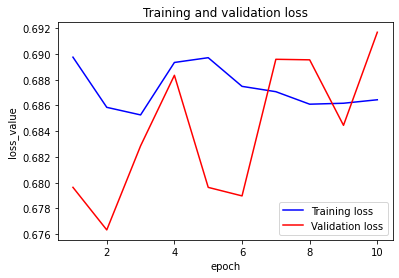

In [ ]:
loss = history.history['loss']
epochs = range(1,len(loss)+1)
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, '-r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.legend()
plt.show()

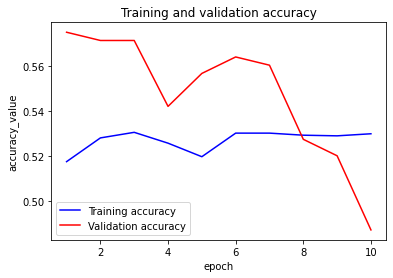

In [ ]:
loss = history.history['accuracy']
epochs = range(1,len(loss)+1)
val_loss = history.history['val_accuracy']
plt.figure()
plt.plot(epochs, loss, 'b', label='Training accuracy')
plt.plot(epochs, val_loss, '-r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy_value')
plt.legend()
plt.show()

**Evaluating on the test dataset**

In [ ]:
result = model.evaluate(dataset_test)
dict(zip(model.metrics_names, result))

8/8 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5175


{'accuracy': 0.5175438523292542, 'loss': 0.6889723539352417}